## CMPINF 2100 Week 13 | Apply Crosss-Validation to Logistic Regression models

We will use `statsmodels` to FIT and make predictions with logistic regression models.

We will use the same data set from Week 12 and FIT all 17 models from Week 12.

We will use CROSS-VALIDATION to estimate the AVERAGE Accuracy on New Data for all 17 models!

The Cross-Validation Accracy metric will be used to identify the BEST model on NEW data!

### Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read Data

Use the week 12 example

In [2]:
df = pd.read_csv('../week_12/week_12_binary_classification.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      300 non-null    float64
 1   x2      300 non-null    float64
 2   x3      300 non-null    float64
 3   x4      300 non-null    float64
 4   x5      300 non-null    object 
 5   y       300 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 14.2+ KB


### Goal

The Goal is to use K-fold Cross-Validation to evaluate the performance of the 17 models from last week!

In [4]:
formula_list = ['y ~ 1', 
                'y ~ x5',
                'y ~ x1 + x2 + x3 + x4',
                'y ~ x1 + x2 + x3 + x4 + x5',
                'y ~ x5 * (x1 + x2 + x3 + x4)',
                'y ~ (x1 + x2 + x3 + x4) ** 2',
                'y ~ x1 + x2 + x3 + x4 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2)',
                'y ~ x5 + x1 + x2 + x3 + x4 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2)',
                'y ~ x5 * (x1 + x2 + x3 + x4 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2))',
                'y ~ x5 + ((x1 + x2 + x3 + x4)**2 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2))',
                'y ~ x5 * ((x1 + x2 + x3 + x4)**2 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2))',
                'y ~ x5 + (x1 + x2 + x3 + x4)**3',
                'y ~x5 + (x1 + x2 + x3 + x4)**4',
                'y ~ (x1 + x2 + x3 + x4 + x5)**3',
                'y ~ (x1 + x2 + x3 + x4 + x5)**4',
                'y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2) + np.power(x1, 3) + np.power(x2, 3) + np.power(x3, 3) + np.power(x4, 3) )',
                'y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2) + np.power(x1, 3) + np.power(x2, 3) + np.power(x3, 3) + np.power(x4, 3) + np.power(x1, 4) + np.power(x2, 4) + np.power(x3, 4) + np.power(x4, 4) )'
               ]

In [5]:
len( formula_list )

17

In [6]:
formula_list[0]

'y ~ 1'

In [7]:
type( formula_list[0] )

str

In [8]:
formula_list[3]

'y ~ x1 + x2 + x3 + x4 + x5'

We will use STRATIFIED cross-validation because we are working on a CLASSIFICATION problem.

In [10]:
from sklearn.model_selection import StratifiedKFold

Let's use 5-fold CV

In [11]:
kf = StratifiedKFold( n_splits=5, shuffle=True, random_state=9483156)

In [12]:
kf.get_n_splits()

5

We will FIT the logistic regression models using STATSMODELS.

In [13]:
import statsmodels.formula.api as smf

We need a few more helper objects that will HELP us execute everything.

We need the COLUMN NAMES for the INPUTS. And we will need the OUTPUT column name.

In [14]:
input_names = df.drop(columns=['y']).copy().columns.to_list()

In [15]:
output_name = 'y'

Let's define a FUNCTION that manages the FITTING and PERFORMANCE METRIC calculation within the Cross-Validation FOLDS!

In [16]:
def train_and_test_logistic_with_cv(mod_name, a_formula, data_df, x_names, y_name, cv, threshold=0.5):
    # seperate the inputs and the output
    input_df = data_df.loc[ :, x_names ].copy()

    # initialize the performance metric storage list
    train_res = []
    test_res = []

    # split the data and iterate over the folds
    for train_id, test_id in cv.split( input_df.to_numpy(), data_df[ y_name ].to_numpy() ):
        # subset the training and test splits within each fold
        train_data = data_df.iloc[ train_id, :].copy()
        test_data = data_df.iloc[ test_id, :].copy()

        # fit the model on the TRAINING data within the current FOLD
        a_mod = smf.logit(formula=a_formula, data=train_data).fit()

        # predict the training within each fold
        train_copy = train_data.copy()
        train_copy['pred_probability'] = a_mod.predict( train_data )
        train_copy['pred_class'] = np.where( train_copy.pred_probability > threshold, 1, 0 )

        # predict the testing within each fold
        test_copy = test_data.copy()
        test_copy['pred_probability'] = a_mod.predict( test_data )
        test_copy['pred_class'] = np.where( test_copy.pred_probability > threshold, 1, 0)

        # calculate the performance metric on the training set within the fold
        train_res.append( np.mean( train_copy[ y_name ] == train_copy.pred_class ) )

        # calculate the performance metirc on the testing set within the fold
        test_res.append( np.mean( test_copy[ y_name ] == test_copy.pred_class ) )

    # book keeping to store results
    train_df = pd.DataFrame({'Accuracy': train_res})
    train_df['from_set'] = 'training'
    train_df['fold_id'] = train_df.index + 1

    test_df = pd.DataFrame({'Accuracy': test_res})
    test_df['from_set'] = 'testing'
    test_df['fold_id'] = test_df.index + 1

    # combine the splits together
    res_df = pd.concat([train_df, test_df], ignore_index=True)

    # add information about the model
    res_df['model_name'] = mod_name
    res_df['model_formula'] = a_formula
    res_df['num_coefs'] = len(a_mod.params)
    res_df['threshold'] = threshold

    return res_df

Test this function on a single model to ensure it works. Let's use the INTERCEPT ONLY or CONSTANT model!

In [17]:
train_and_test_logistic_with_cv(0, formula_list[0], data_df=df, x_names=input_names, y_name=output_name, cv=kf)

Optimization terminated successfully.
         Current function value: 0.639363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642135
         Iterations 4


,Accuracy,from_set,fold_id,model_name,model_formula,num_coefs,threshold
0,0.662500,training,1,0,y ~ 1,1,0.5
1,0.662500,training,2,0,y ~ 1,1,0.5
2,0.658333,training,3,0,y ~ 1,1,0.5
3,0.658333,training,4,0,y ~ 1,1,0.5
4,0.658333,training,5,0,y ~ 1,1,0.5
5,0.650000,testing,1,0,y ~ 1,1,0.5
6,0.650000,testing,2,0,y ~ 1,1,0.5
7,0.666667,testing,3,0,y ~ 1,1,0.5
8,0.666667,testing,4,0,y ~ 1,1,0.5
9,0.666667,testing,5,0,y ~ 1,1,0.5


Let's try again on a more complex model!

In [18]:
formula_list[3]

'y ~ x1 + x2 + x3 + x4 + x5'

In [19]:
train_and_test_logistic_with_cv(3, formula_list[3], data_df=df, x_names=input_names, y_name=output_name, cv=kf)

Optimization terminated successfully.
         Current function value: 0.572898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586447
         Iterations 5


,Accuracy,from_set,fold_id,model_name,model_formula,num_coefs,threshold
0,0.675000,training,1,3,y ~ x1 + x2 + x3 + x4 + x5,7,0.5
1,0.637500,training,2,3,y ~ x1 + x2 + x3 + x4 + x5,7,0.5
2,0.670833,training,3,3,y ~ x1 + x2 + x3 + x4 + x5,7,0.5
3,0.645833,training,4,3,y ~ x1 + x2 + x3 + x4 + x5,7,0.5
4,0.687500,training,5,3,y ~ x1 + x2 + x3 + x4 + x5,7,0.5
5,0.566667,testing,1,3,y ~ x1 + x2 + x3 + x4 + x5,7,0.5
6,0.700000,testing,2,3,y ~ x1 + x2 + x3 + x4 + x5,7,0.5
7,0.633333,testing,3,3,y ~ x1 + x2 + x3 + x4 + x5,7,0.5
8,0.716667,testing,4,3,y ~ x1 + x2 + x3 + x4 + x5,7,0.5
9,0.600000,testing,5,3,y ~ x1 + x2 + x3 + x4 + x5,7,0.5


In [20]:
formula_list[14]

'y ~ (x1 + x2 + x3 + x4 + x5)**4'

In [21]:
train_and_test_logistic_with_cv(14, formula_list[14], data_df=df, x_names=input_names, y_name=output_name, cv=kf)

Optimization terminated successfully.
         Current function value: 0.481118
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.468108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.473089
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.497845
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460337
         Iterations 8


,Accuracy,from_set,fold_id,model_name,model_formula,num_coefs,threshold
0,0.745833,training,1,14,y ~ (x1 + x2 + x3 + x4 + x5)**4,46,0.5
1,0.775000,training,2,14,y ~ (x1 + x2 + x3 + x4 + x5)**4,46,0.5
2,0.754167,training,3,14,y ~ (x1 + x2 + x3 + x4 + x5)**4,46,0.5
3,0.745833,training,4,14,y ~ (x1 + x2 + x3 + x4 + x5)**4,46,0.5
4,0.758333,training,5,14,y ~ (x1 + x2 + x3 + x4 + x5)**4,46,0.5
5,0.633333,testing,1,14,y ~ (x1 + x2 + x3 + x4 + x5)**4,46,0.5
6,0.600000,testing,2,14,y ~ (x1 + x2 + x3 + x4 + x5)**4,46,0.5
7,0.566667,testing,3,14,y ~ (x1 + x2 + x3 + x4 + x5)**4,46,0.5
8,0.650000,testing,4,14,y ~ (x1 + x2 + x3 + x4 + x5)**4,46,0.5
9,0.533333,testing,5,14,y ~ (x1 + x2 + x3 + x4 + x5)**4,46,0.5


The model with a large number of regresion coefficients that need estimated has **WORSE** test set performance than training set performance!

Let's now apply 5-fold CV to ALL 17 model which range from SIMPLE to VERY COMPLEX

### EXECUTE Cross-Validation

In [22]:
results_list = []

for m in range( len(formula_list) ):
    print( '-- Formula ID %d --' %m )

    results_list.append( train_and_test_logistic_with_cv(m, formula_list[m], data_df=df, x_names=input_names, y_name=output_name, cv=kf) )

-- Formula ID 0 --
Optimization terminated successfully.
         Current function value: 0.639363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642135
         Iterations 4
-- Formula ID 1 --
Optimization terminated successfully.
         Current function value: 0.629771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636496
         Iterations 5
Optimization terminated successfully.
      

C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix

How can we overcome this ERROR?!

Let's use a very simple stategy, let's use a TRY/EXCEPT procedure.

This strategy involves TRYING something and then if an ERROR or EXCEPTION is raised print a message.

In [23]:
results_list = []

for m in range( len(formula_list) ):
    print('-- Formula ID %d --' % m )

    try:
        results_list.append( train_and_test_logistic_with_cv(m, formula_list[m], data_df=df, x_names=input_names, y_name=output_name, cv=kf) )
    except:
        # what happens if there is an ERROR
        print( ' !!! Formula ID %d could NOT fit !!! ' %m)
        

-- Formula ID 0 --
Optimization terminated successfully.
         Current function value: 0.639363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642135
         Iterations 4
-- Formula ID 1 --
Optimization terminated successfully.
         Current function value: 0.629771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636496
         Iterations 5
Optimization terminated successfully.
      

C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


In [24]:
len( results_list )

16

In [25]:
len( formula_list )

17

This means, our last FORMULA which COULD FIT on the ENTIRE data set... does **NOT** work if we SPLIT the data!

Combine the results for all models that DID work!

In [26]:
cv_results = pd.concat( results_list, ignore_index=True)

In [27]:
cv_results

,Accuracy,from_set,fold_id,model_name,model_formula,num_coefs,threshold
0,0.662500,training,1,0,y ~ 1,1,0.5
1,0.662500,training,2,0,y ~ 1,1,0.5
2,0.658333,training,3,0,y ~ 1,1,0.5
3,0.658333,training,4,0,y ~ 1,1,0.5
4,0.658333,training,5,0,y ~ 1,1,0.5
...,...,...,...,...,...,...,...
155,0.666667,testing,1,15,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,69,0.5
156,0.633333,testing,2,15,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,69,0.5
157,0.600000,testing,3,15,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,69,0.5
158,0.616667,testing,4,15,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,69,0.5


In [28]:
cv_results.model_name.value_counts()

model_name
0     10
1     10
2     10
3     10
4     10
5     10
6     10
7     10
8     10
9     10
10    10
11    10
12    10
13    10
14    10
15    10
Name: count, dtype: int64

C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


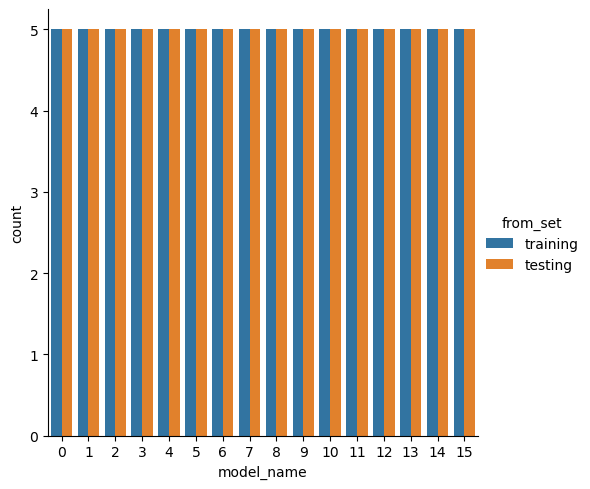

In [29]:
sns.catplot(data = cv_results, x='model_name', hue='from_set', kind='count')

plt.show()

Let's look at the Accuracy values for each model in each fold in the TRAINING and TEST sets!

C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


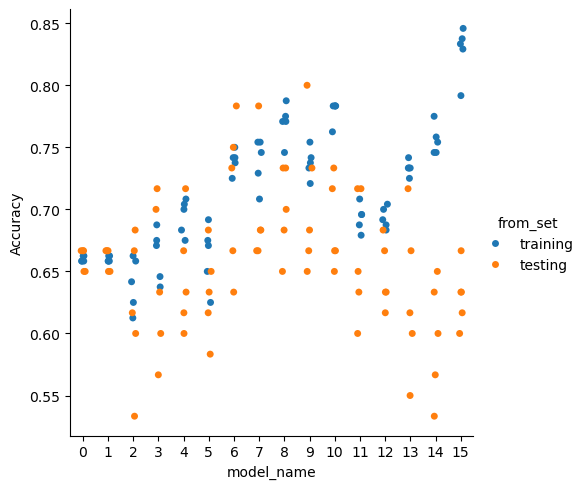

In [30]:
sns.catplot( data = cv_results, x='model_name', y='Accuracy', hue='from_set')

plt.show()

Instead, we are typically concerned with the AVERAGE performance!

But I will first overlay the AVERAGE with the FOLD results.

C:\Users\Canye\AppData\Local\Temp\ipykernel_35476\2894161676.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', join=False, ax=ax)


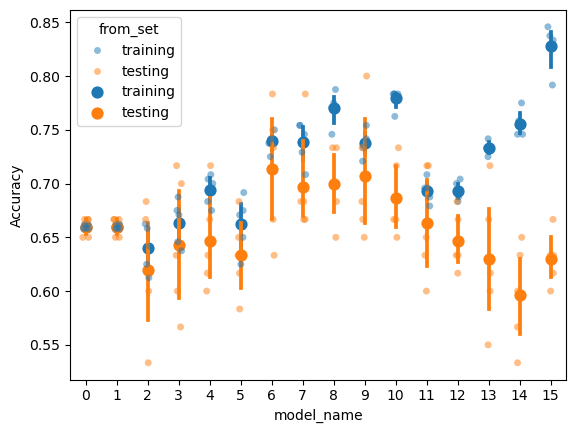

In [31]:
fig, ax = plt.subplots()

sns.stripplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', alpha=0.5, ax=ax)

sns.pointplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', join=False, ax=ax)

plt.show()

Let's just focus on the AVERAGE, so summarize the cross-validation results using a POINT PLOT.

C:\Users\Canye\AppData\Local\Temp\ipykernel_35476\3054396630.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', kind='point', join=False)
C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


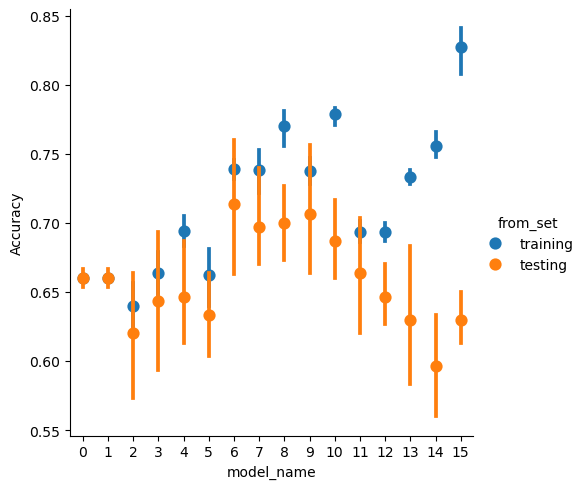

In [32]:
sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', kind='point', join=False)

plt.show()

More frequently though, and in practice, the above figure ONLY shows the TEST SET performance!

The POINT PLOT shows the 95% confidence interval by default, but when COMPARING MODELS the convention is to show the 68% confidence interval because that corresponds to the 1 standard error interval.

C:\Users\Canye\AppData\Local\Temp\ipykernel_35476\955638718.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.catplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],
C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


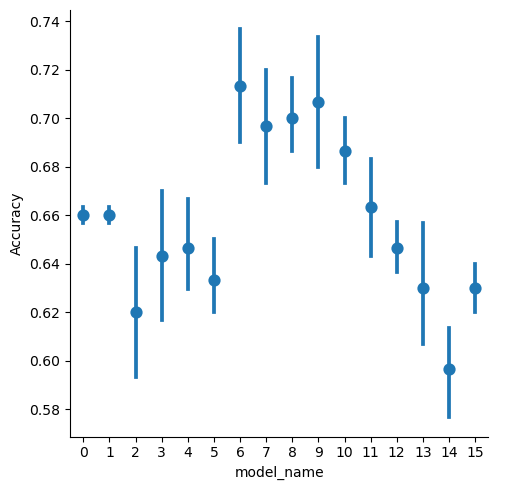

In [35]:
sns.catplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],
            x='model_name', y='Accuracy', kind='point', join=False,
            errorbar=('ci', 68))

plt.show()

One standard error rule choose the SIMPLEST BEST model!

Let's confirm the performance based on the number of coefficients.

In [36]:
cv_results

,Accuracy,from_set,fold_id,model_name,model_formula,num_coefs,threshold
0,0.662500,training,1,0,y ~ 1,1,0.5
1,0.662500,training,2,0,y ~ 1,1,0.5
2,0.658333,training,3,0,y ~ 1,1,0.5
3,0.658333,training,4,0,y ~ 1,1,0.5
4,0.658333,training,5,0,y ~ 1,1,0.5
...,...,...,...,...,...,...,...
155,0.666667,testing,1,15,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,69,0.5
156,0.633333,testing,2,15,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,69,0.5
157,0.600000,testing,3,15,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,69,0.5
158,0.616667,testing,4,15,y ~ x5 * (( x1 + x2 + x3 + x4)**3 + np.power(x...,69,0.5


C:\Users\Canye\AppData\Local\Temp\ipykernel_35476\1089939512.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.catplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],
C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


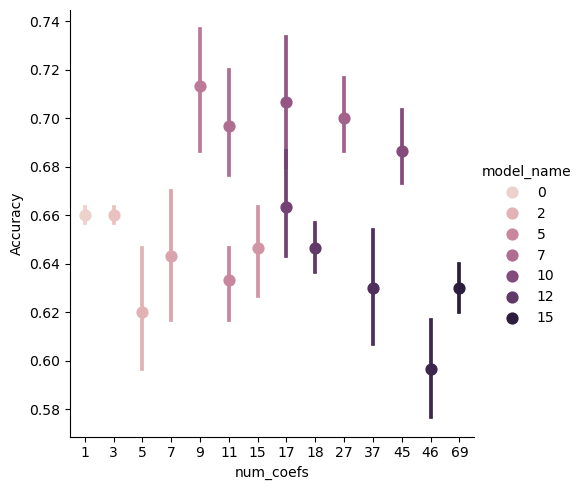

In [37]:
sns.catplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],
            x='num_coefs', y='Accuracy', kind='point', join=False,
            hue='model_name', 
            errorbar=('ci', 68))

plt.show()

In [38]:
formula_list[6]

'y ~ x1 + x2 + x3 + x4 + np.power(x1, 2) + np.power(x2, 2) + np.power(x3, 2) + np.power(x4, 2)'

### Model Selection

Chose the mdoel that does the BEST **on average** on NEW data!

We must FIT the model one final time using the ENTIRE data set!

In [39]:
best_model = smf.logit( formula=formula_list[6], data=df).fit()

Optimization terminated successfully.
         Current function value: 0.513238
         Iterations 7


In [40]:
best_model.pvalues < 0.05

Intercept          False
x1                  True
x2                  True
x3                 False
x4                 False
np.power(x1, 2)     True
np.power(x2, 2)     True
np.power(x3, 2)    False
np.power(x4, 2)    False
dtype: bool

In [41]:
np.abs( best_model.params[ best_model.pvalues < 0.05 ] ).sort_values(ascending=False)

x2                 0.988749
np.power(x1, 2)    0.683793
np.power(x2, 2)    0.623668
x1                 0.510771
dtype: float64

You can use the above approach to identify the RANKING of the FEATURES when the INPUTS are STANDARDIZED!

Visualize the PREDICTIVE trends for the INPUTS.

In [42]:
input_grid = pd.DataFrame([ (x1, x2, x3, x4, x5) for x1 in np.linspace(df.x1.min(), df.x1.max(), num=101)
                                                 for x2 in np.linspace(df.x2.min(), df.x2.max(), num=9)
                                                 for x3 in [df.x3.mean()]
                                                 for x4 in [df.x4.mean()]
                                                 for x5 in df.x5.unique() ],
                          columns=['x1', 'x2', 'x3', 'x4', 'x5'])

In [43]:
input_grid.nunique()

x1    101
x2      9
x3      1
x4      1
x5      3
dtype: int64

In [44]:
dfviz = input_grid.copy()

In [45]:
dfviz['pred_probability'] = best_model.predict( input_grid )

In [46]:
dfviz

,x1,x2,x3,x4,x5,pred_probability
0,-2.913116,-3.008946,0.002302,0.001372,c,0.000060
1,-2.913116,-3.008946,0.002302,0.001372,b,0.000060
2,-2.913116,-3.008946,0.002302,0.001372,a,0.000060
3,-2.913116,-2.242719,0.002302,0.001372,c,0.000343
4,-2.913116,-2.242719,0.002302,0.001372,b,0.000343
...,...,...,...,...,...,...
2722,2.783826,2.354646,0.002302,0.001372,b,0.000080
2723,2.783826,2.354646,0.002302,0.001372,a,0.000080
2724,2.783826,3.120873,0.002302,0.001372,c,0.000003
2725,2.783826,3.120873,0.002302,0.001372,b,0.000003


C:\Users\Canye\anaconda3\envs\cmpinf2100\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


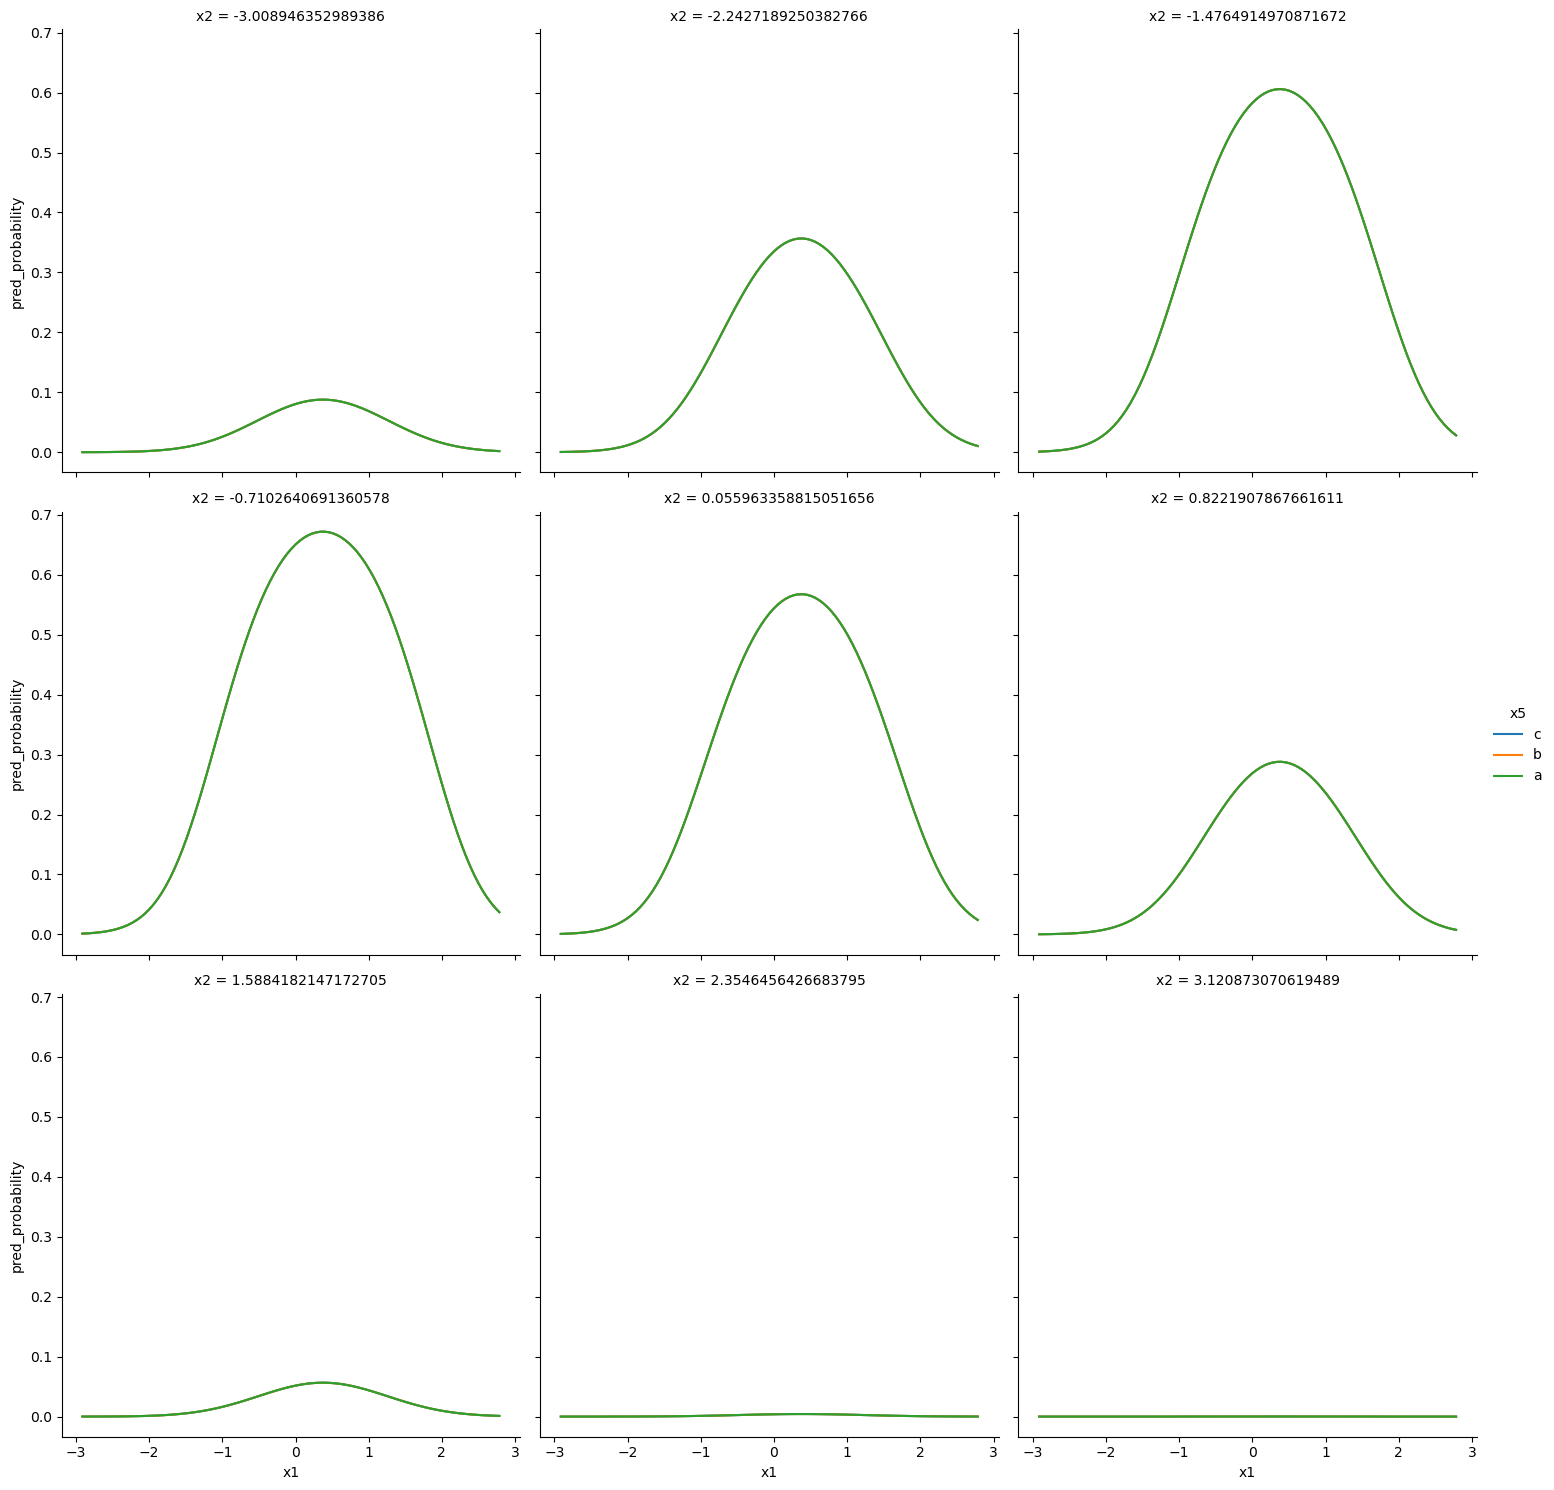

In [48]:
sns.relplot(data = dfviz, x='x1', y='pred_probability', hue='x5', col='x2',
            kind='line', estimator=None, units='x5',
            col_wrap=3)

plt.show()